# Python Final Project: Bike Sharing Prediction


### Introduction

	The goal of this assignment is to predict the total count of bike rentals during each hour. This notebook explains how we can explore and prepare the data for model building. For this purpose, we have structured the project into the following steps:
    
1.	Data Summary


2.	Feature Engineering: Part I


3.	Missing Value Analysis


4.	Exploratory data analysis 


5.	Outlier Analysis


6.	Correlation Analysis


7. Feature Engineering: Part II


10.	Linear Regression Model


11.	Decision Tree


12.	Random Forest Regression


13.	XGBoost



In [36]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:

import dask.dataframe as dd
from dask_ml.preprocessing import Categorizer, DummyEncoder, StandardScaler
from dask_ml.linear_model import LogisticRegression
from dask_ml.xgboost import XGBRegressor
from dask.distributed import Client
from sklearn.externals.joblib import parallel_backend
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

from scipy.stats import skew, pearsonr

In [3]:
# load dataset and set "instant" as index column
df_hour = dd.read_csv("https://s3.us-east-2.amazonaws.com/bikedata/hour.csv")
df_hour

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
npartitions=1,,,,,,,,,,,,,,,,,
,int64,object,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


# 1.	Data Summary

Size of the dataset and type of variables present in our data.

In [65]:
df_hour.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 16 entries, instant to cnt
dtypes: category(1), category(1), category(3), category(1), category(2), datetime64[ns](1), float64(3), int64(4)

# 2.	Feature Engineering: Part I

After having a look at the Data Summary results, we observed that the columns "season", "holiday", "workingday", "weather", “weekday”, “weathersit”, “mnth”, “yr”, “hr” should be of "categorical" data type. Therefore, we transform the dataset in the following ways to start the EDA process:
- Date-time conversion.
- Coerce the datatype of "season","holiday","workingday", “weather “, “weekday”, “weathersit”, “mnth”, “yr” and “hr” to category.

In [4]:
# set appropriate variable types
# date time conversion
df_hour["dteday"] = dd.to_datetime(df_hour.dteday)

# categorical variables
df_hour["season"] = df_hour.season.astype("category")
df_hour["holiday"] = df_hour.holiday.astype("category")
df_hour["weekday"] = df_hour.weekday.astype("category")
df_hour["weathersit"] = df_hour.weathersit.astype("category")
df_hour["workingday"] = df_hour.workingday.astype("category")
df_hour["mnth"] = df_hour.mnth.astype("category")
df_hour["yr"] = df_hour.yr.astype("category")
df_hour["hr"] = df_hour.hr.astype("category")

In [10]:
df_hour.describe()

,instant,temp,hum,windspeed,casual,registered,cnt
npartitions=1,,,,,,,
,int64,float64,float64,float64,int64,int64,int64
,...,...,...,...,...,...,...


In [11]:
df_hour.compute()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.76,0.0000,8,6,14


# 3.	Missing Value Analysis

Next step was to find out whether we have any missing values in our data. Luckily we dont have any missing value in the dataset. 

In [7]:
# check for missing values
sum(df_hour.isna().values.any())

0

# 4. Exploratory Data Analysis

In [68]:
# Configuring plotting visual and sizes
sns.set_style("whitegrid")
sns.set_context("talk")
params = {
    "legend.fontsize": "x-large",
    "figure.figsize": (30, 10),
    "axes.labelsize": "x-large",
    "axes.titlesize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
}

plt.rcParams.update(params)

/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0.5, 1.0, 'Bike sharing demand over time')]

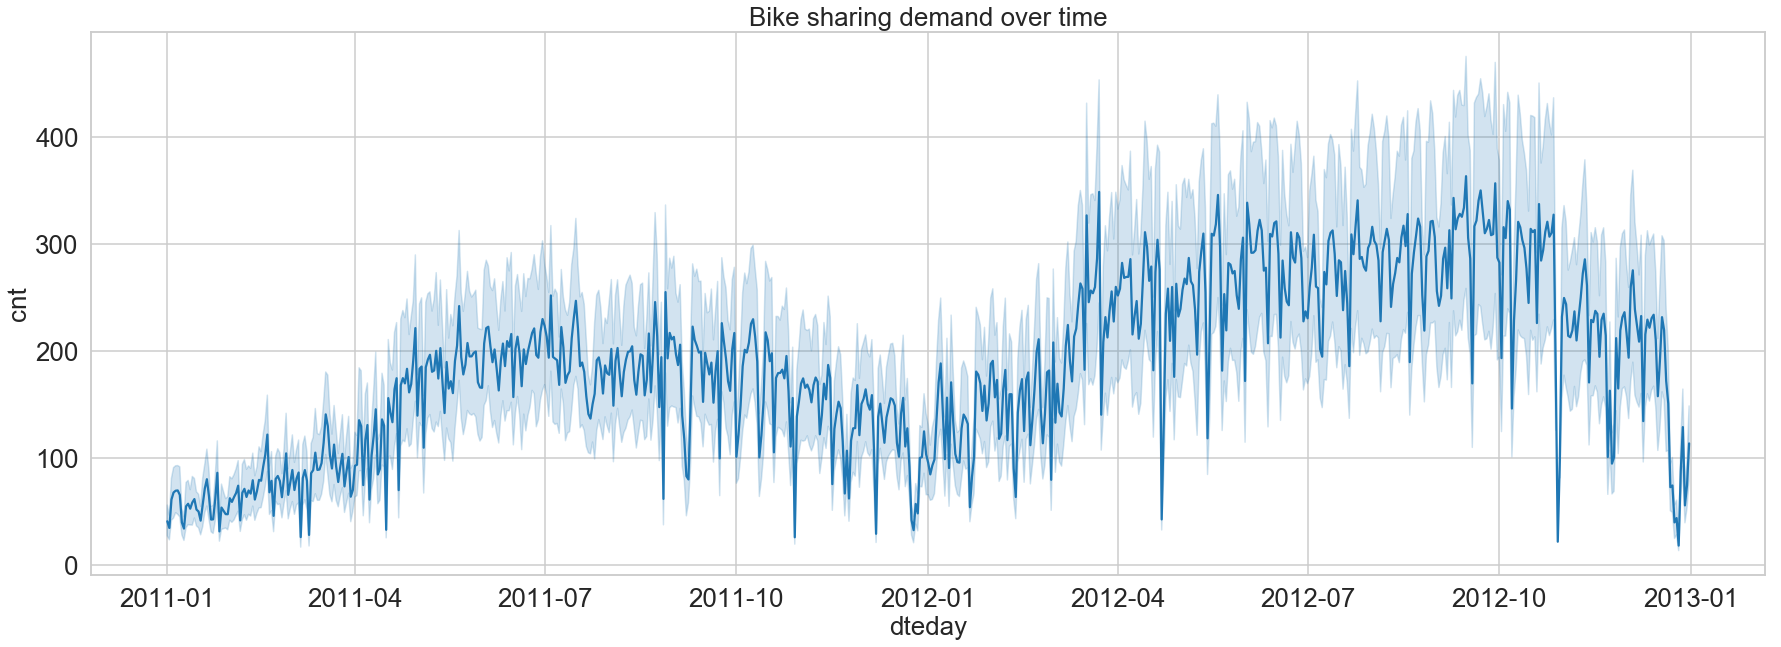

In [ ]:
#Time Series plot
fig, ax = plt.subplots()
sns.lineplot(
    data=df_hour[["dteday", "cnt"]].compute(), x="dteday", y="cnt", ax=ax,
)
ax.set(title="Bike sharing demand over time")

###  Visualizing Distribution of the data

[Text(0.5, 1.0, 'Counts variable distribution')]

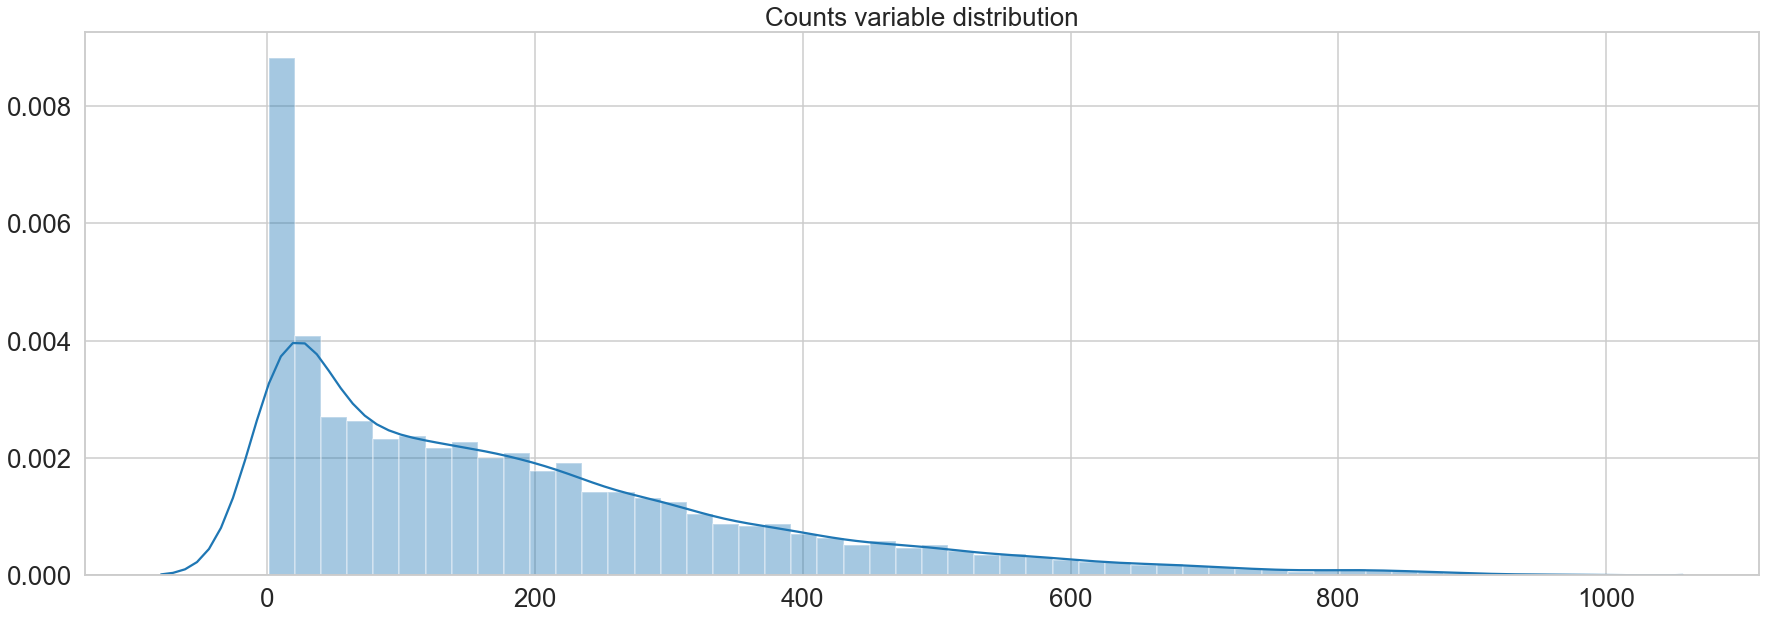

In [28]:
# target variable distribution
fig, ax = plt.subplots()
sns.distplot(df_hour[["cnt"]])
ax.set(title="Counts variable distribution")

The distribution of counts is very skewed to the right, with a big concentration of lower values.

[Text(0.5, 1.0, 'Temperature distribution')]

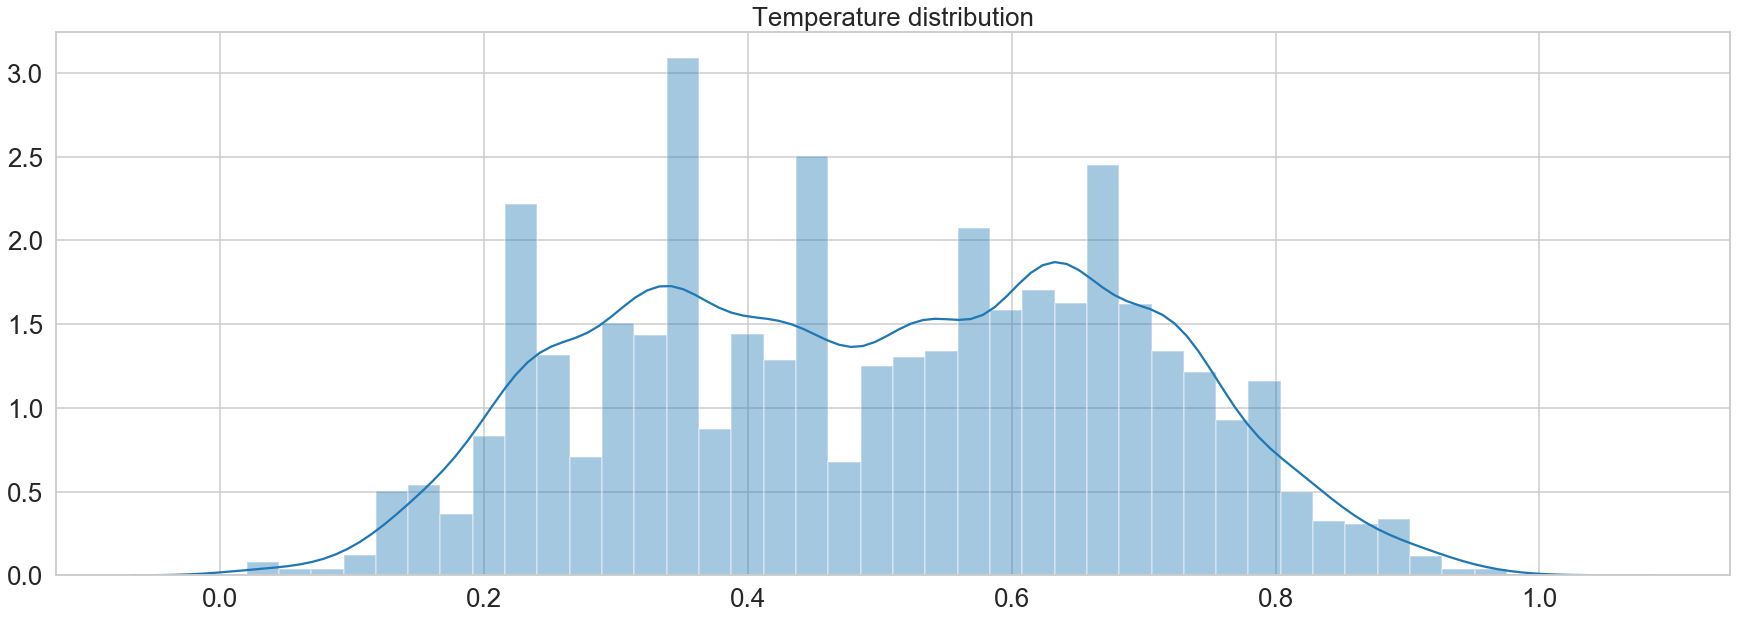

In [29]:
# temperature distribution
fig, ax = plt.subplots()
sns.distplot(df_hour[["temp"]])
ax.set(title="Temperature distribution")

[Text(0.5, 1.0, 'Humidity distribution')]

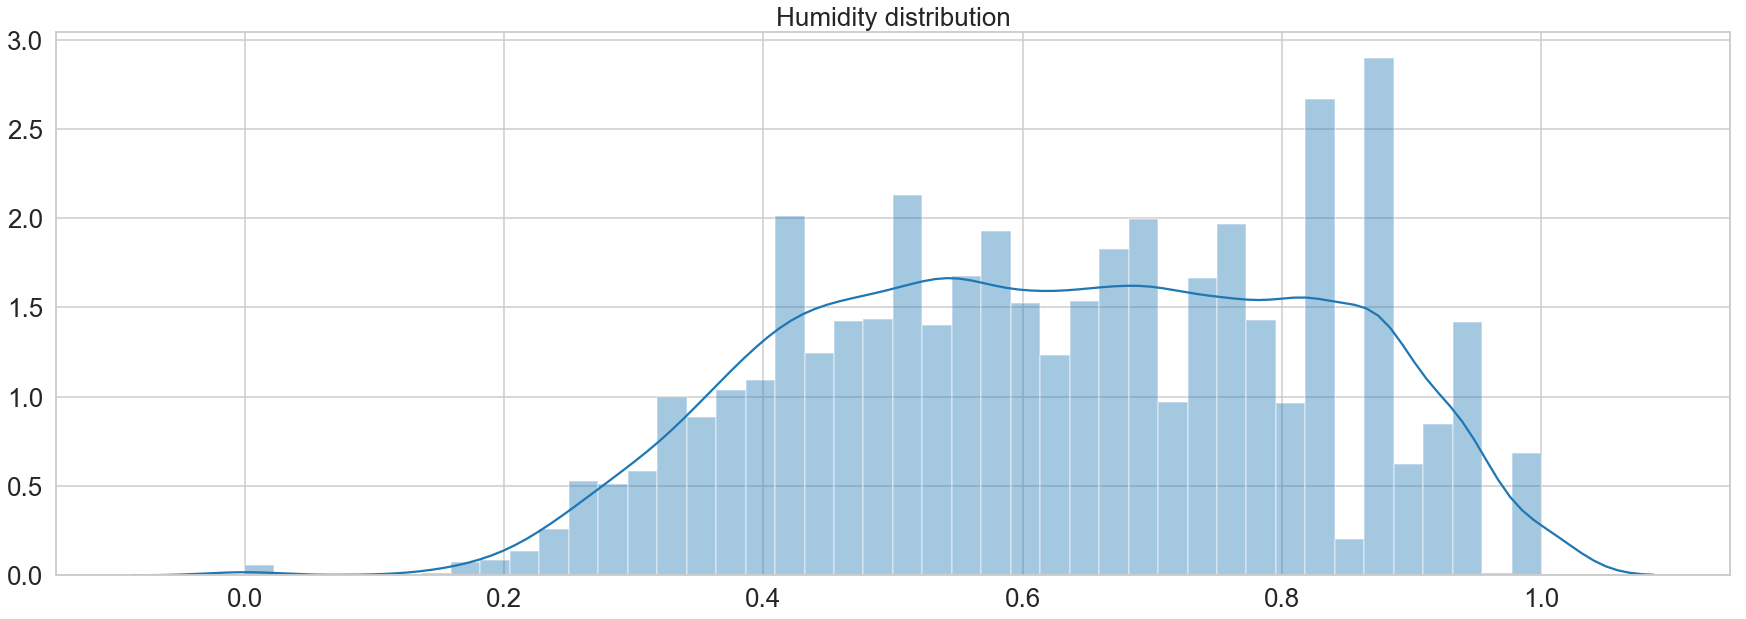

In [30]:
# Humidity distribution
fig, ax = plt.subplots()
sns.distplot(df_hour[["hum"]])
ax.set(title="Humidity distribution")

[Text(0.5, 1.0, 'Windspeed distribution')]

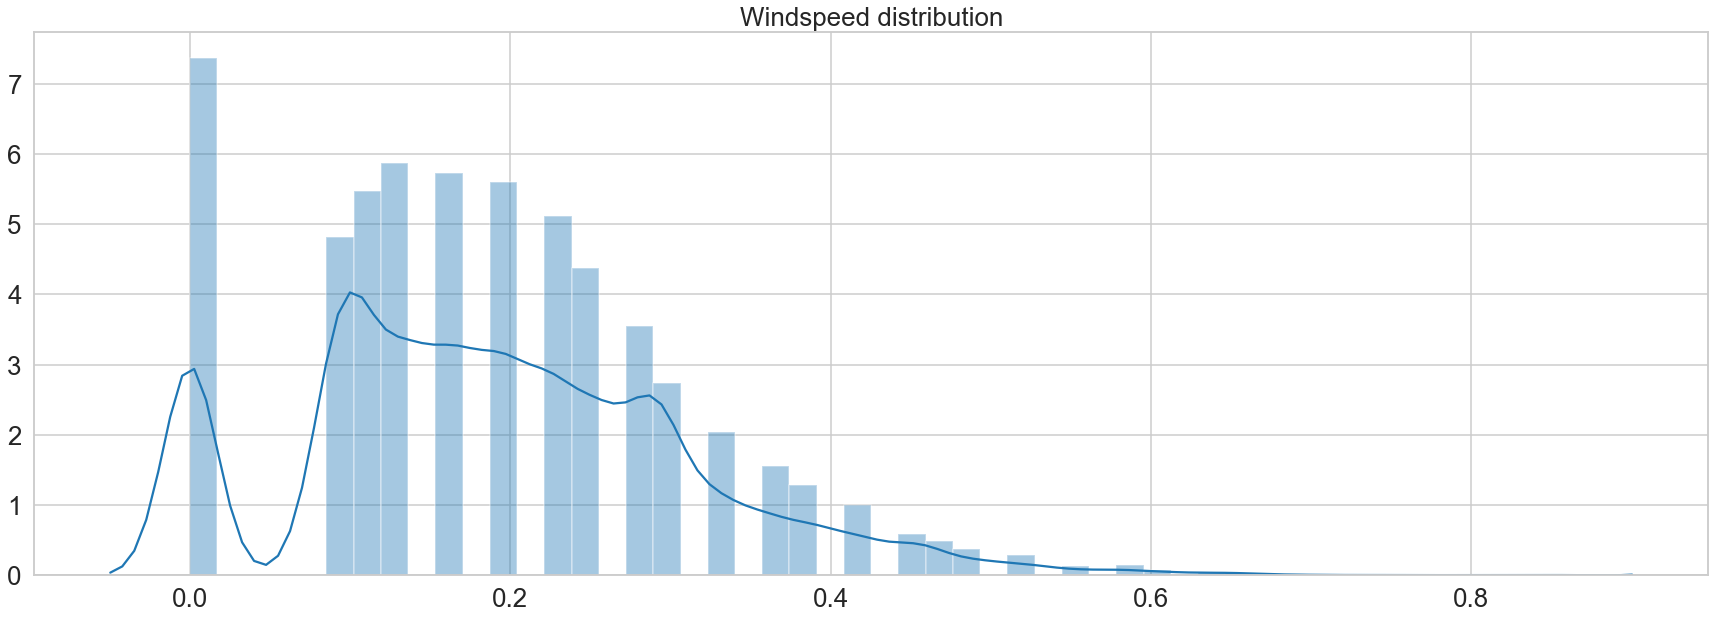

In [31]:
# Windspeed distribution
fig, ax = plt.subplots()
sns.distplot(df_hour[["windspeed"]])
ax.set(title="Windspeed distribution")

dd.Scalar<series-..., dtype=float64>


/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0.5, 1.0, 'Windspeed distribution')]

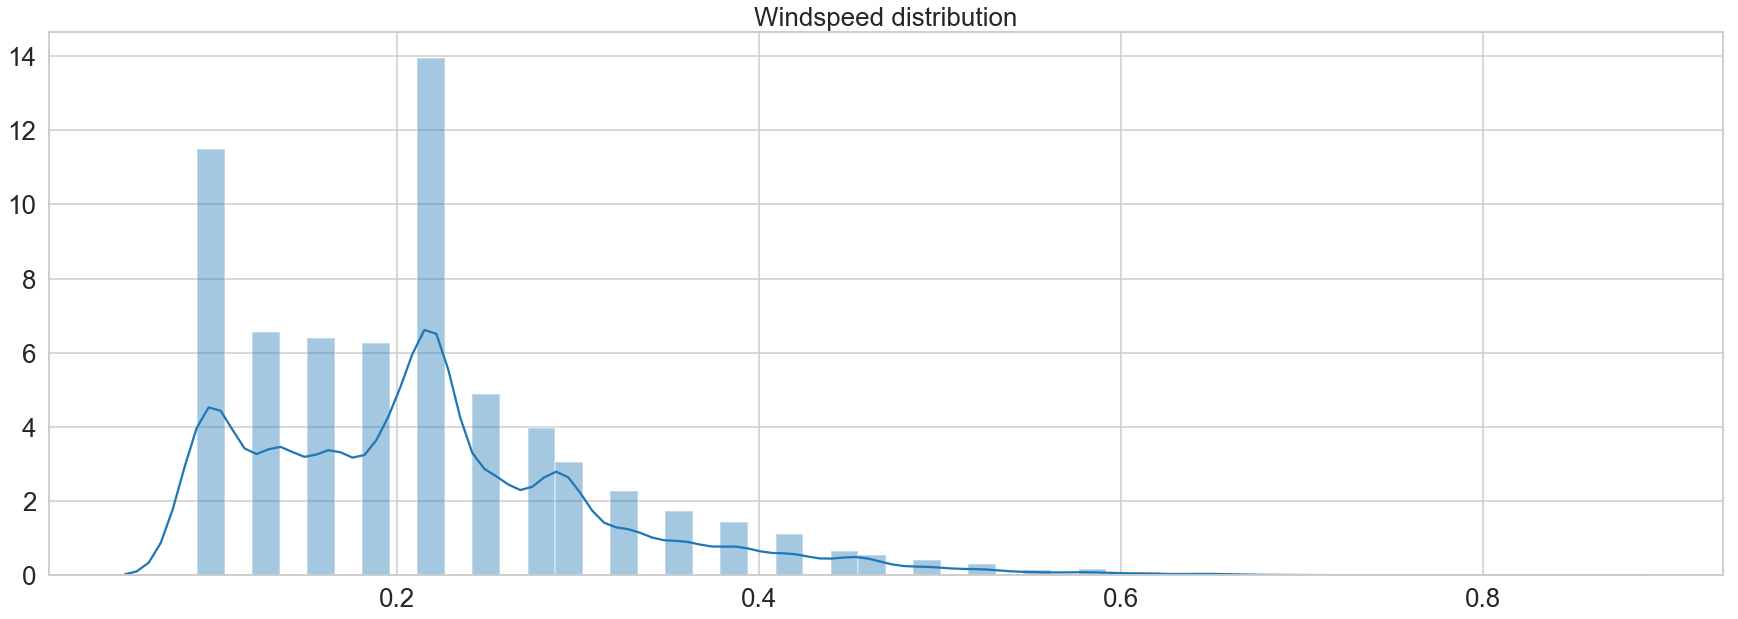

In [32]:
mean_windspeed = df_hour[df_hour["windspeed"] != 0]["windspeed"].mean(skipna=True)
print(mean_windspeed)
df_hour["windspeed"] = df_hour.windspeed.mask(df_hour.windspeed == 0,mean_windspeed)
fig, ax = plt.subplots()
sns.distplot(df_hour[["windspeed"]])
ax.set(title="Windspeed distribution")

### Visualizing Count Vs year

/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0.5, 1.0, 'Counts in 2011 and 2012')]

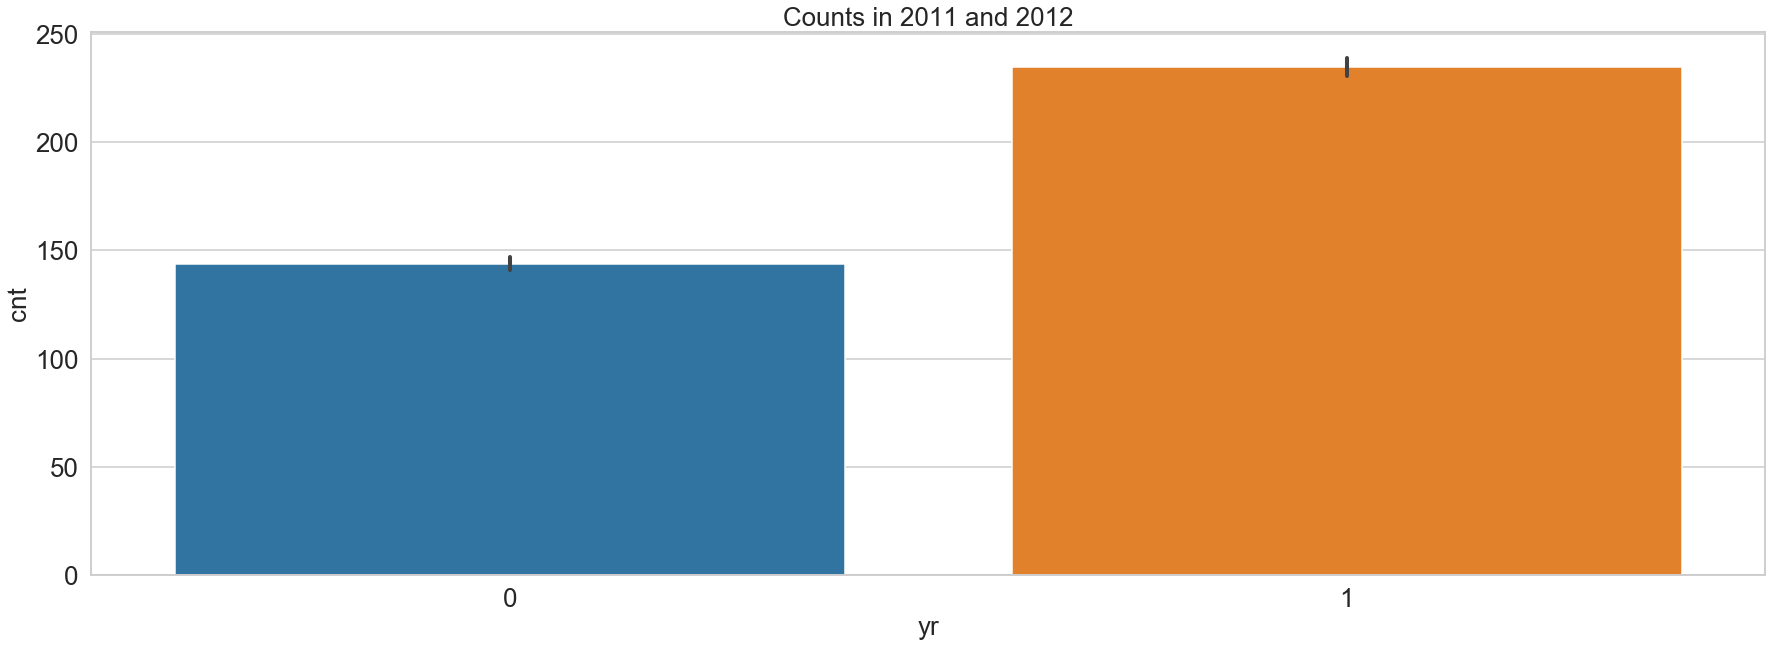

In [ ]:
# check count in each year
fig, ax = plt.subplots()
sns.barplot(data=df_hour[["yr", "cnt"]].compute(), x="yr", y="cnt", ax=ax)
ax.set(title="Counts in 2011 and 2012")

There was a big increase in demand from 2011 to 2012.

### Visualizing Count Vs month

/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0.5, 1.0, 'Monthly distribution of counts')]

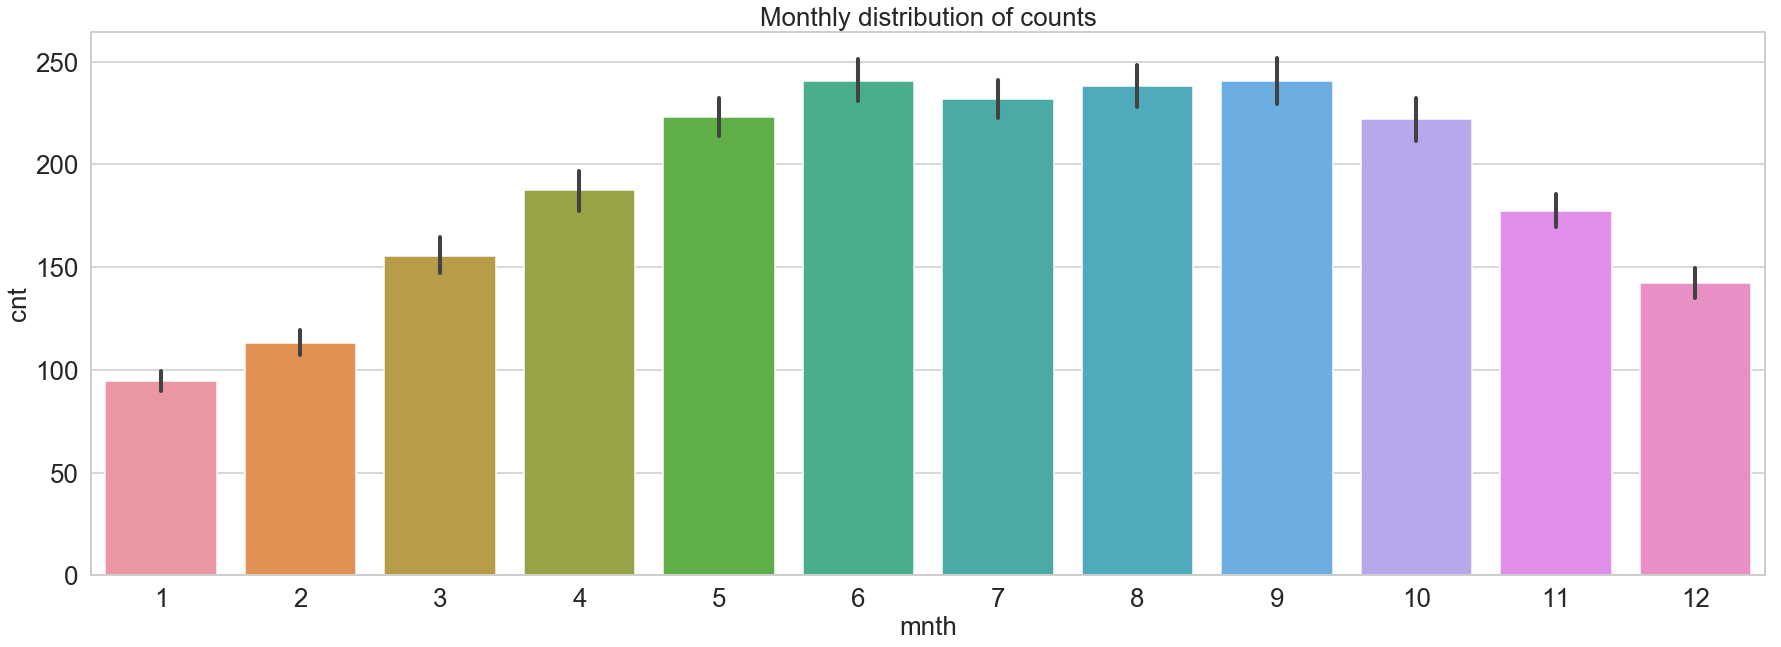

In [ ]:
# check distribution of count per month
fig, ax = plt.subplots()
sns.barplot(data=df_hour[["mnth", "cnt"]].compute(), x="mnth", y="cnt", ax=ax)
ax.set(title="Monthly distribution of counts")

Demand is higher from May to October.

### Visualizing hour distribution of count Vs month

In [ ]:
fig, ax = plt.subplots()
sns.pointplot(data=df_hour[["hr", "cnt", "mnth"]].compute(), x="hr", y="cnt", hue="mnth", ax=ax)
ax.set(title="Hourly distribution of counts per month")

/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


### Visualizing Count Vs season

/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0.5, 1.0, 'Seasonal distribution of counts')]

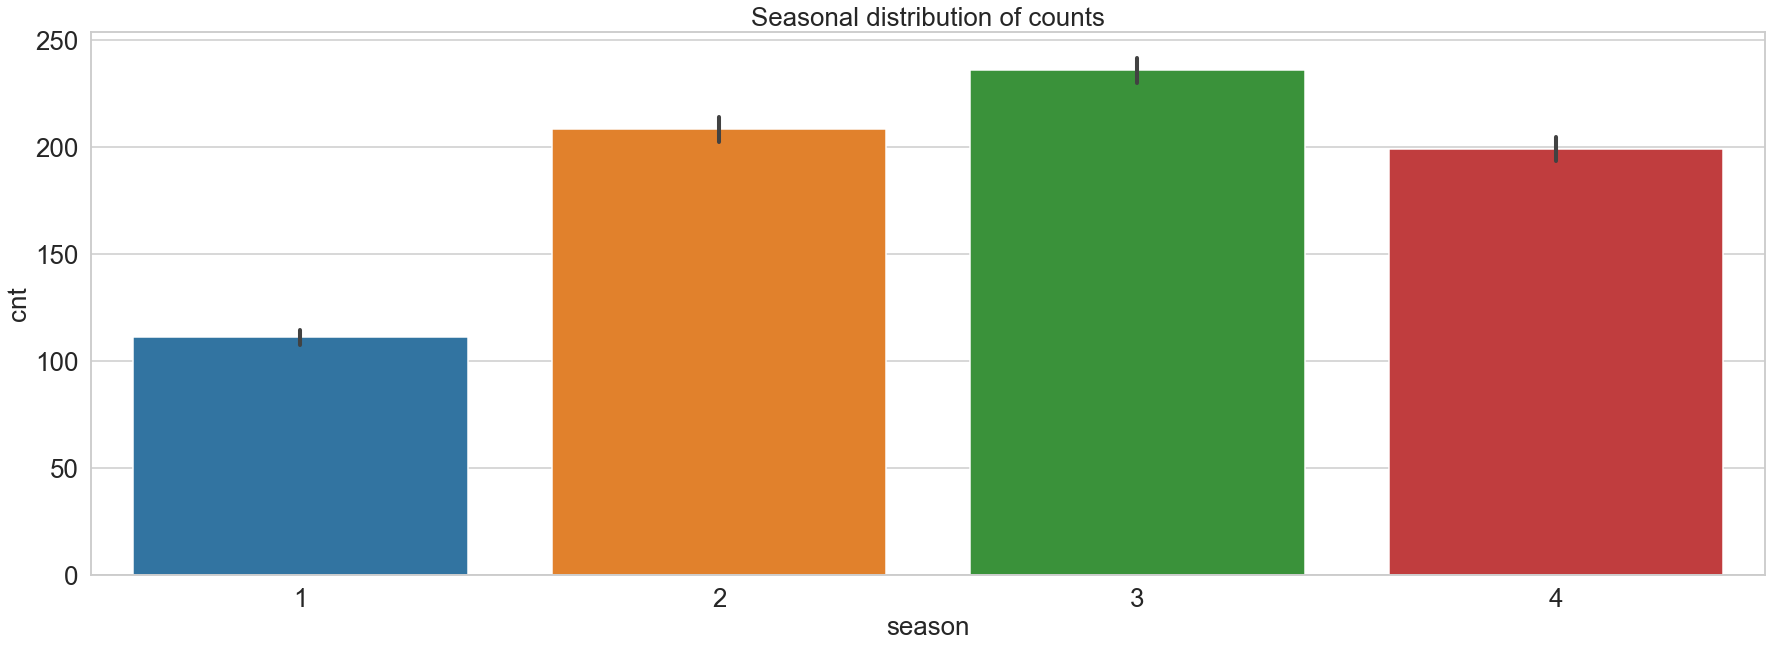

In [33]:
# check count distribution per season
fig, ax = plt.subplots()
sns.barplot(data=df_hour[["season", "cnt"]].compute(), x="season", y="cnt", ax=ax)
ax.set(title="Seasonal distribution of counts")

Winter(1) is the season with lowest demand, while the other 3 are somewhat similar.

### Visualizing hour distribution Count Vs season

/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0.5, 1.0, 'Season wise hourly distribution of counts')]

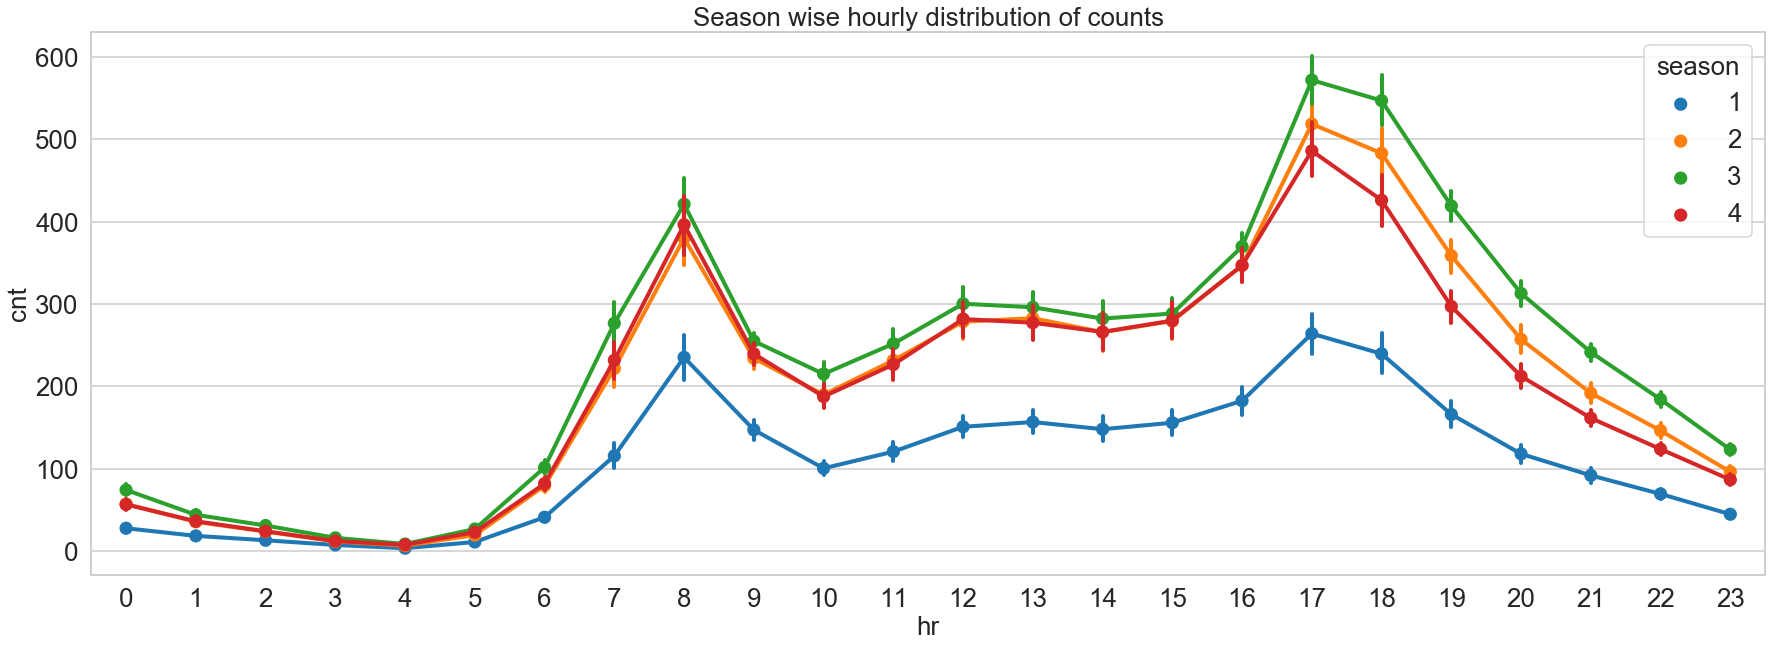

In [34]:
fig, ax = plt.subplots()
sns.pointplot(
    data=df_hour[["hr", "cnt", "season"]].compute(), x="hr", y="cnt", hue="season", ax=ax
)
ax.set(title="Season wise hourly distribution of counts")

We see in the chart that the trend in the distribution of count per hour remains the same accross all seasons, with peaks at around 8am and 17-18pm.

### Visualizing Count distribution Vs weekday

/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0.5, 1.0, 'Daily distribution of counts')]

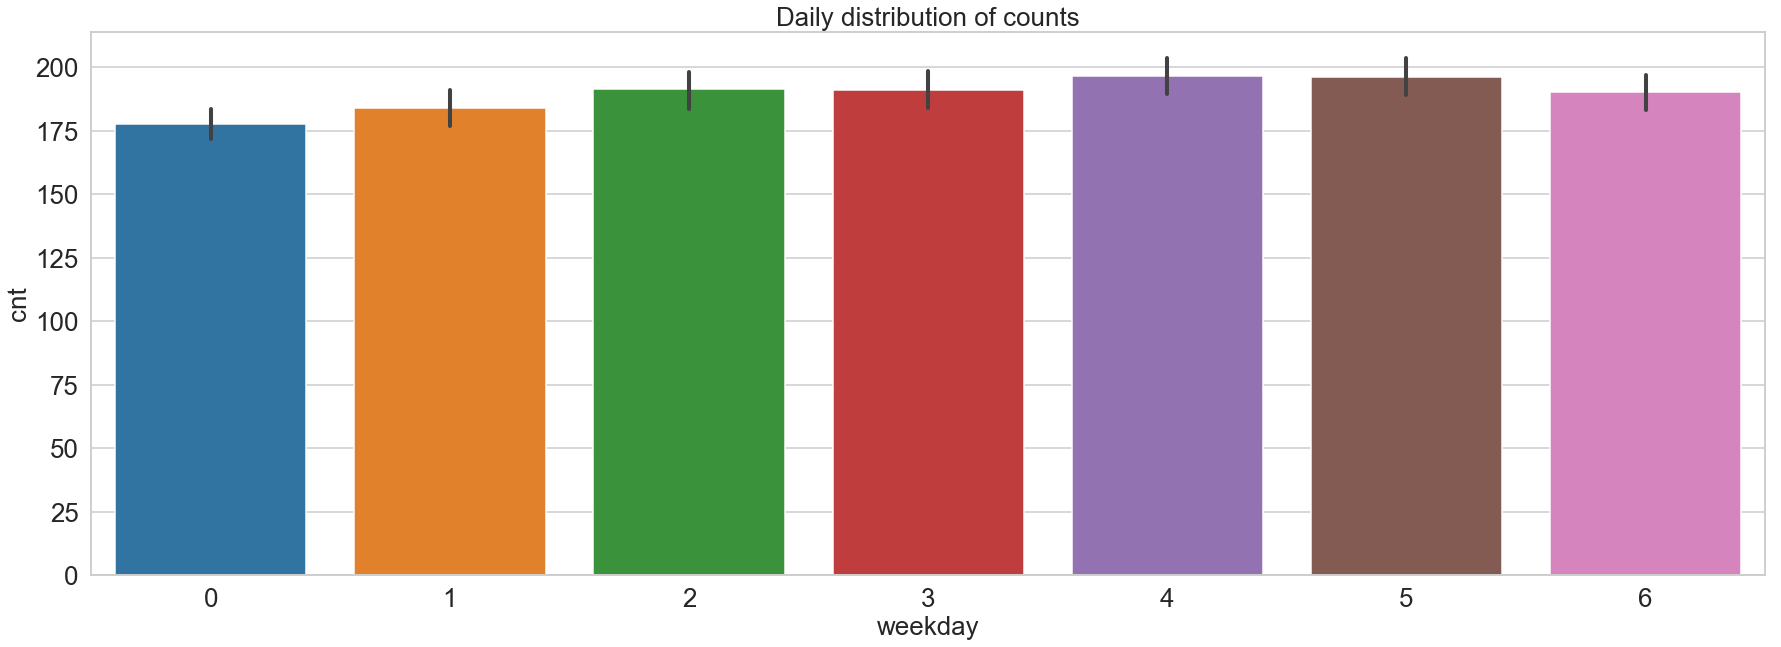

In [35]:
# check count distribution per weekday
fig, ax = plt.subplots()
sns.barplot(data=df_hour[["weekday", "cnt"]].compute(), x="weekday", y="cnt", ax=ax)
ax.set(title="Daily distribution of counts")

Demand is similar in all seven days of the week.

### Visualizing hour distribution of Count Vs weekday

/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0.5, 1.0, 'Weekday wise hourly distribution of counts')]

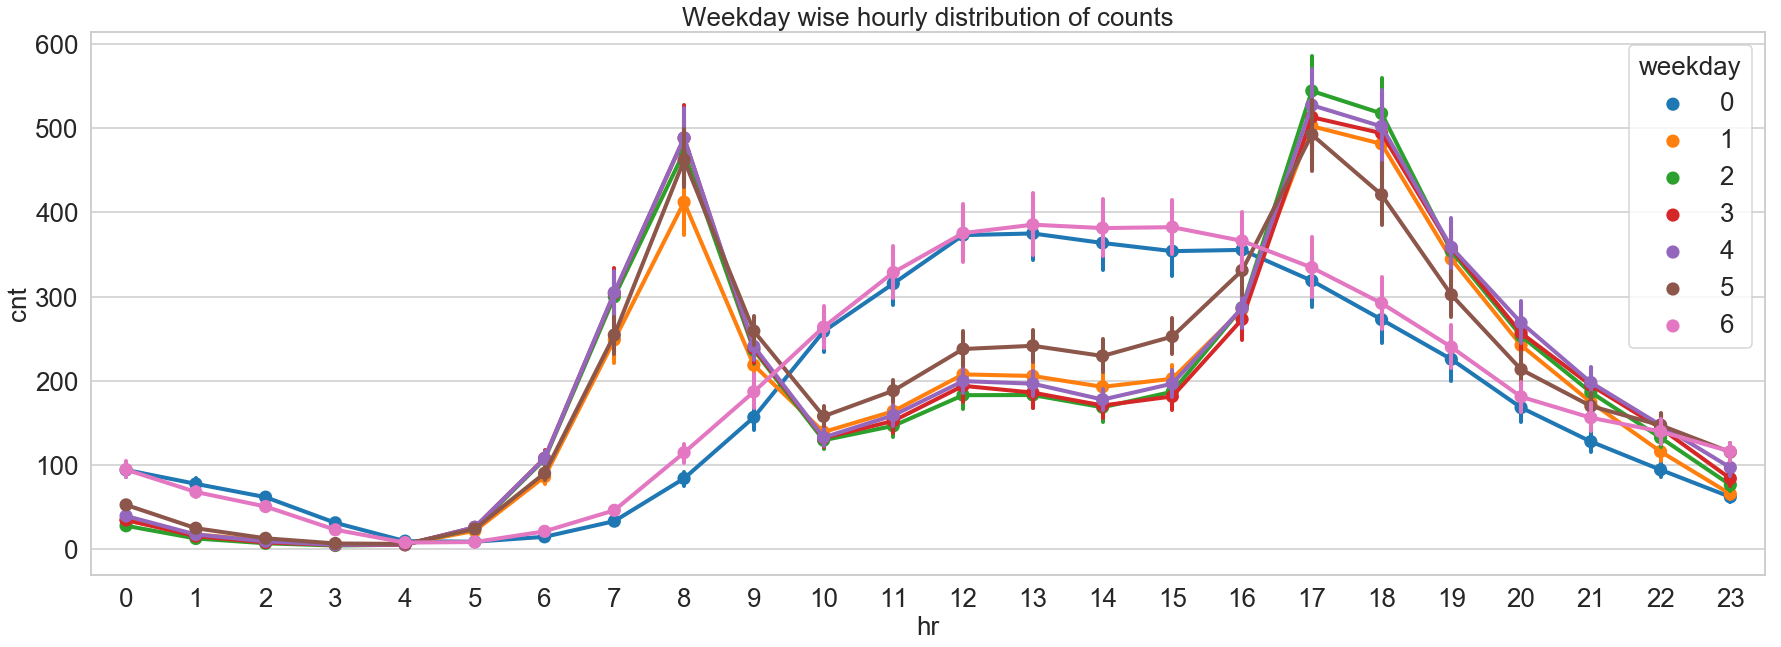

In [36]:
fig, ax = plt.subplots()
sns.pointplot(
    data=df_hour[["hr", "cnt", "weekday"]].compute(), x="hr", y="cnt", hue="weekday", ax=ax
)
ax.set(title="Weekday wise hourly distribution of counts")

We can spot in the charts that the peak hours are reversed for Saturday and Sunday, when most of the demand occurs from 10am to 16pm, as opposed to weekdays, where demand peaks at 8am an 17-18pm.

### Visualizing Count distribution in working day Vs holidays/weekends

/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0.5, 1.0, 'Distribution of counts is working vs non-working days')]

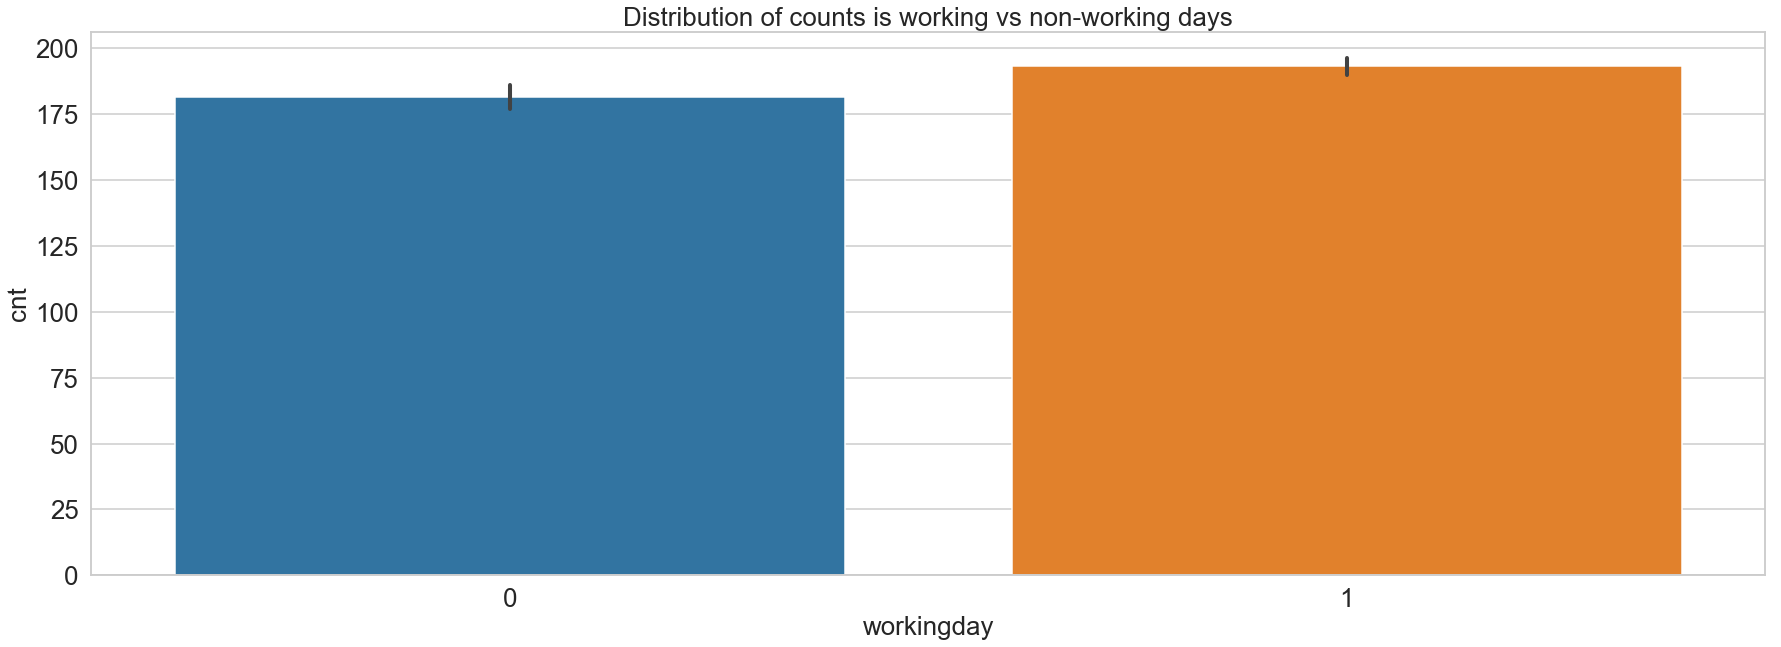

In [37]:
fig, ax = plt.subplots()
sns.barplot(data=df_hour[["workingday", "cnt"]].compute(), x="workingday", y="cnt", ax=ax)
ax.set(title="Distribution of counts is working vs non-working days")

Counts are slightly higher in working days.

### Visualizing hour distribution of count Vs non-working weekday

/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0.5, 1.0, 'Working vs non-working days hourly distribution of counts')]

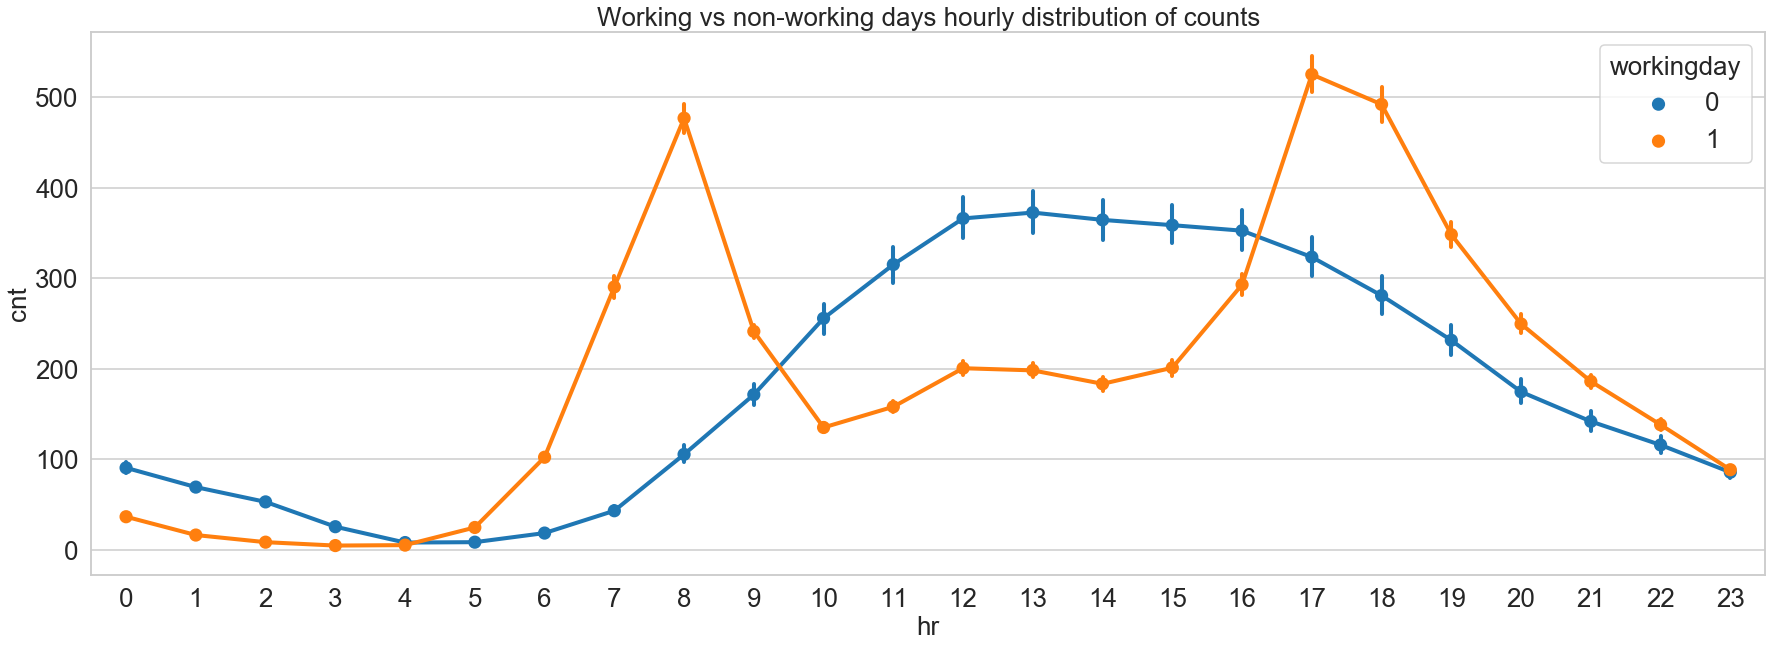

In [38]:
fig, ax = plt.subplots()
sns.pointplot(
    data=df_hour[["hr", "cnt", "workingday"]].compute(), x="hr", y="cnt", hue="workingday", ax=ax
)
ax.set(title="Working vs non-working days hourly distribution of counts")

As seen previously, peak hours are reversed for working and non working days, the first peaking at 8am and 17-18pm and the latter with higher demand from 10am to 16pm. 

### Visualizing Count distribution Vs weather situation

/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0, 0, '1: Clear'),
 Text(0, 0, '2: Mist'),
 Text(0, 0, '3: Light Snow'),
 Text(0, 0, '4: Heavy Rain')]

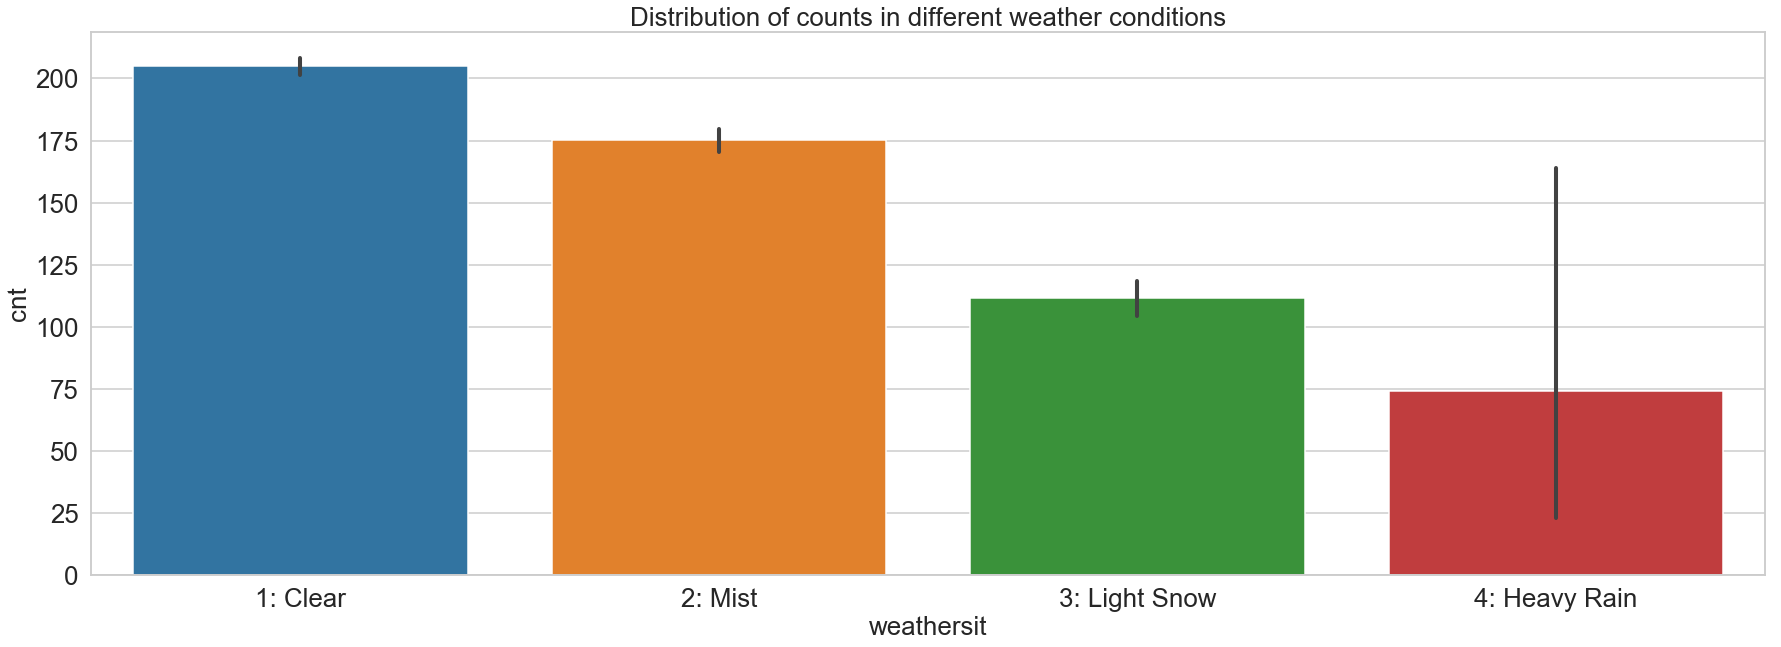

In [39]:
fig, ax = plt.subplots()
sns.barplot(data=df_hour[["weathersit", "cnt"]].compute(), x="weathersit", y="cnt", ax=ax)
ax.set(title="Distribution of counts in different weather conditions")
ax.set_xticklabels(['1: Clear','2: Mist','3: Light Snow','4: Heavy Rain'])

As expected, the better the weather conditions, the more bikes are rented by users.

### Visualizing Count distribution Vs different weather conditions

/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0.5, 1.0, 'Hourly distribution of counts according to weather situation')]

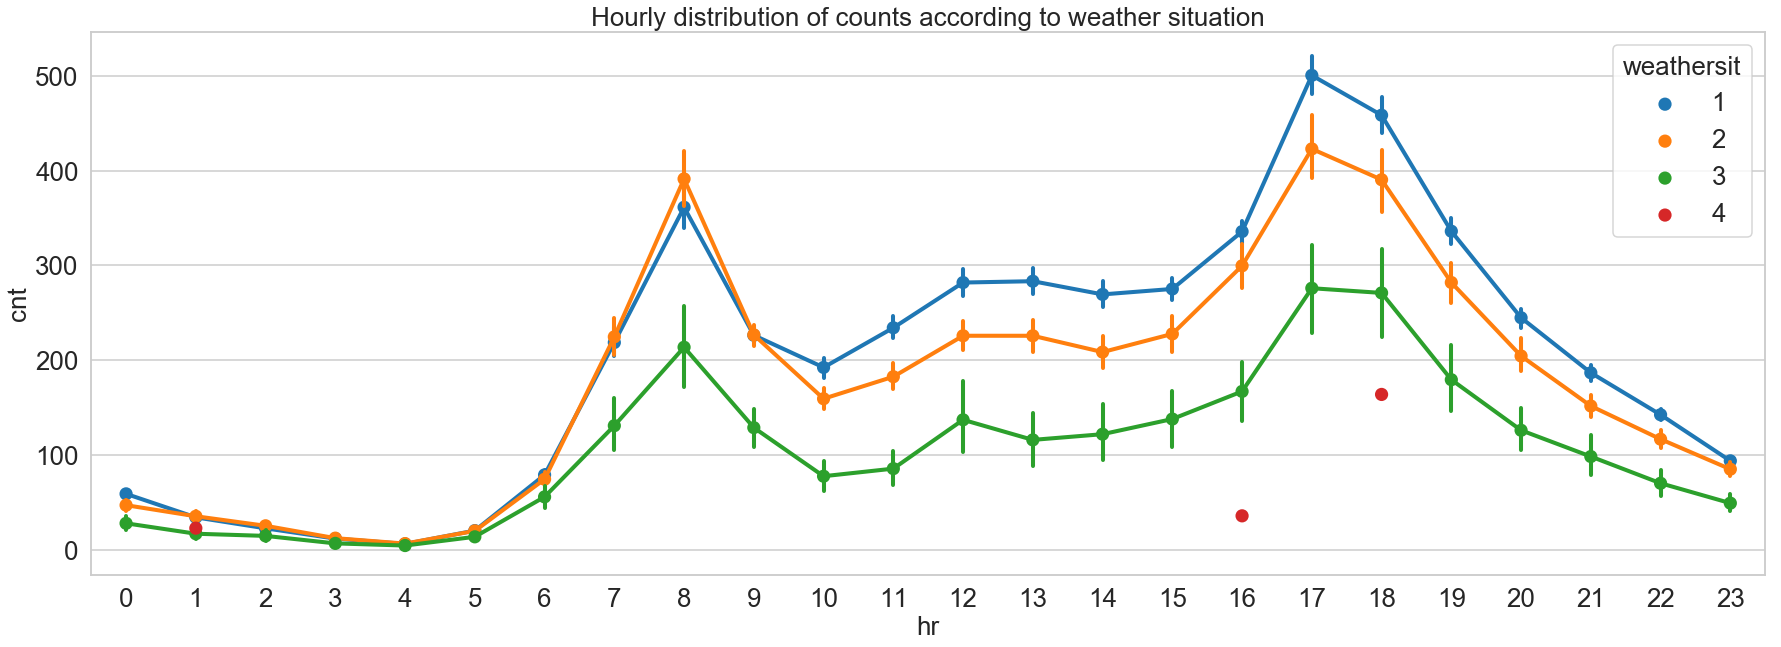

In [40]:
fig, ax = plt.subplots()
sns.pointplot(
    data=df_hour[["hr", "cnt", "weathersit"]].compute(), x="hr", y="cnt", hue="weathersit", ax=ax
)
ax.set(title="Hourly distribution of counts according to weather situation")

At first look, "count" variable contains lot of outliers which skews the distribution to the right.

### Visualizing Count Vs windspeed and humidity since they present outliers.

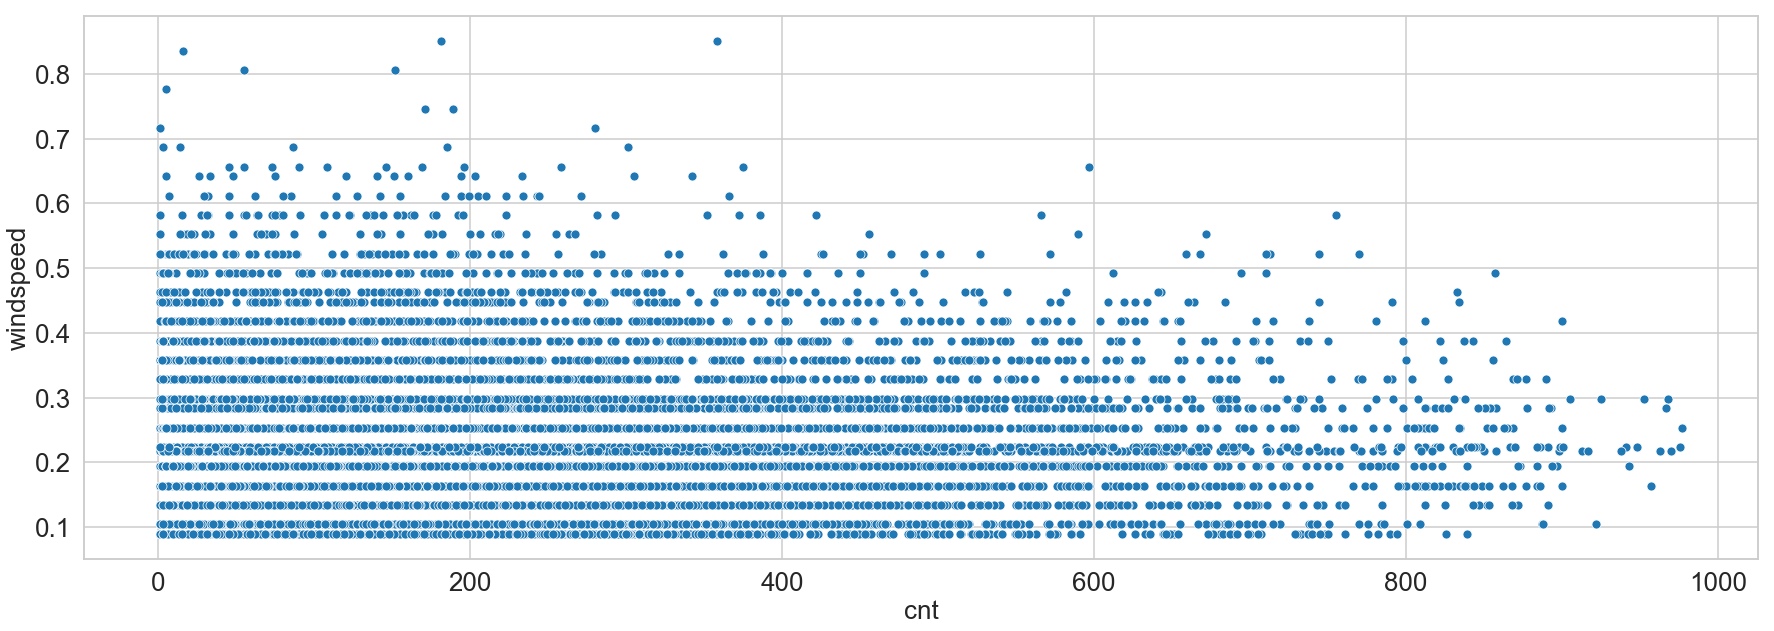

In [41]:
sns.scatterplot(data=df_hour[['cnt', 'windspeed']].compute(),
                x='cnt', y='windspeed')

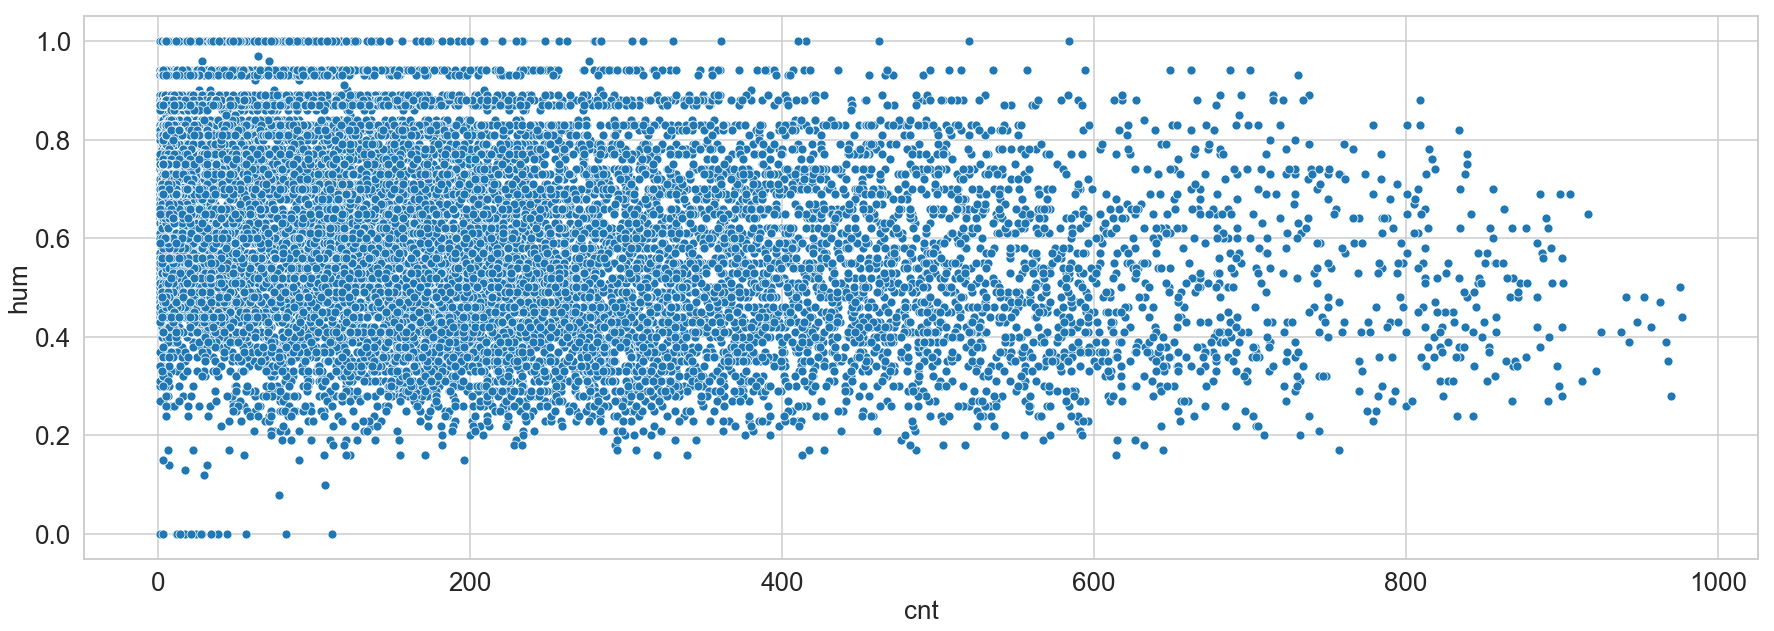

In [42]:
sns.scatterplot(data=df_hour[['cnt', 'hum']].compute(),
                x='cnt', y='hum')

# 5. Outlier Analysis

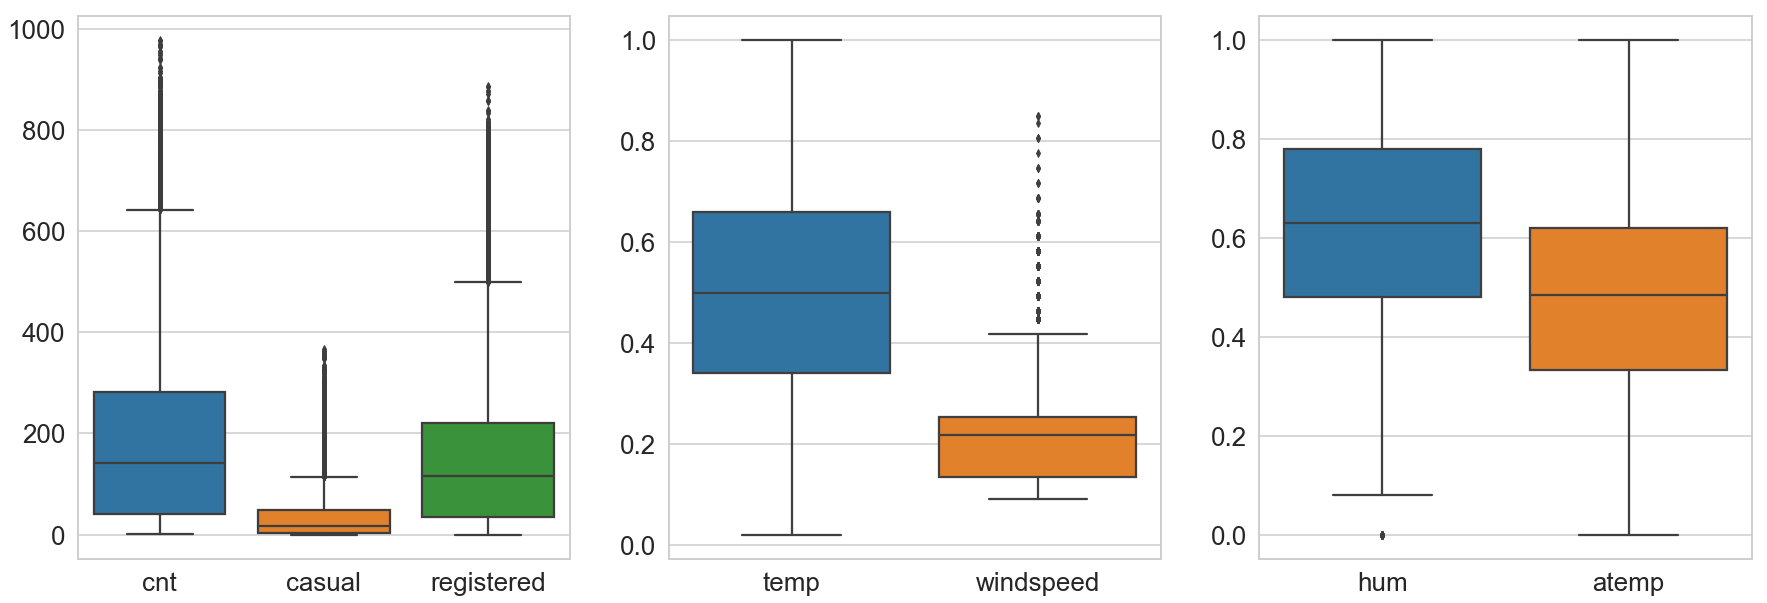

In [43]:
sns.set_style('whitegrid')
sns.set_context('talk')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (30, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)

fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
sns.boxplot(data=df_hour[['cnt',
                          'casual',
                          'registered']].compute(),ax=ax1)
sns.boxplot(data=df_hour[['temp',
                          'windspeed']].compute(),ax=ax2)
sns.boxplot(data=df_hour[['hum', 'atemp']].compute(),ax=ax3)



# 6. Correlation Analysis

In [44]:
#correlations
corrMatt = df_hour[['temp',
                    'atemp', 
                    'hum', 
                    'windspeed', 
                    'casual', 
                    'registered', 
                    'cnt']].corr().compute()
corrMatt

,temp,atemp,hum,windspeed,casual,registered,cnt
temp,1.000000,0.987672,-0.069881,-0.039144,0.459616,0.335361,0.404772
atemp,0.987672,1.000000,-0.051918,-0.068131,0.454080,0.332559,0.400929
hum,-0.069881,-0.051918,1.000000,-0.280111,-0.347028,-0.273933,-0.322911
windspeed,-0.039144,-0.068131,-0.280111,1.000000,0.074646,0.061390,0.071517
casual,0.459616,0.454080,-0.347028,0.074646,1.000000,0.506618,0.694564
registered,0.335361,0.332559,-0.273933,0.061390,0.506618,1.000000,0.972151
cnt,0.404772,0.400929,-0.322911,0.071517,0.694564,0.972151,1.000000


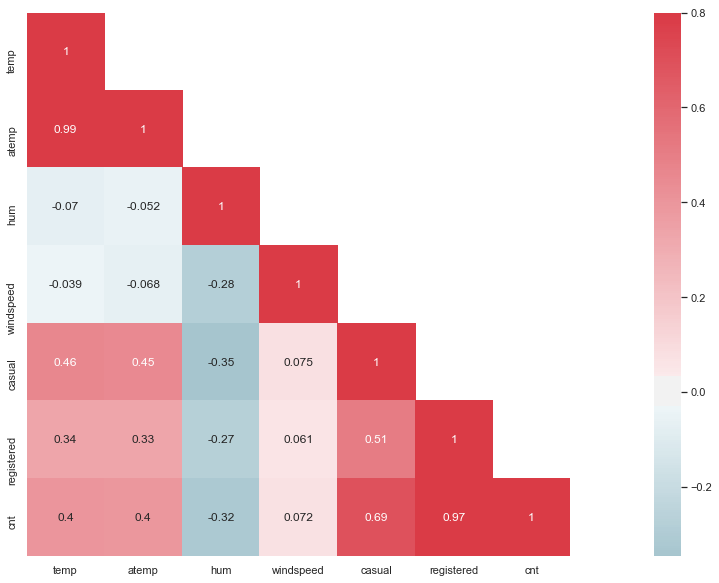

In [45]:
# Now, let's plot the correlations that we have calculated into a matrix for an easier understanding.

sns.set(style="white")
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)]= False


# Generate a colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask
sns.heatmap(corrMatt, mask=mask, cmap=cmap, vmax=.8, center=0,
            square=True, annot=True)

After visualizing the correlation matrix we can see that "temp' and "humidity" have positive and negative correlation with count. Although neither of them present a big correlation eith count there is a little dependency.
The variables "atemp" and "temp" presents a strong correlation so we should not consider "atemp" as a relevant feature when building the model.
The variables "casual" and "registered should not be taken into account since they are leakage variables.
Finally, the variable "windspeed" is not a relevante feature for the modeling section and should not be consider.


In [5]:
df_hour = df_hour.drop(["atemp"], axis=1)

### EDA Conclusions
The main conclusions for this EDA analysis is that people tend to rent bike during summer season since it is more appealing. That explains why in the months of June, July and August occurs a higher demand for renting a bike that any other months.
During weekdays more people tend to rent the bikes at 7-8 am and at 5-6pm. Nevertheless, this patterns are not observed on weekends where the peah hour is from 10 pm to 4pm.

# 7. Feature Engineering: Part II

In [6]:
df_hour = df_hour.categorize()
df_hour.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'casual',
       'registered', 'cnt'],
      dtype='object')

In [7]:
#feature engineering: encode categorical variables
df_dummy=dd.get_dummies(df_hour)
df_dummy.head()

,instant,dteday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,weekday_3,weekday_4,weekday_5,weekday_6,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,1,2011-01-01,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,1,1,0,1,0,0,0
1,2,2011-01-01,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,1,1,0,1,0,0,0
2,3,2011-01-01,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,1,1,0,1,0,0,0
3,4,2011-01-01,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,1,1,0,1,0,0,0
4,5,2011-01-01,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,1,1,0,1,0,0,0


In [8]:
# divide train and test set
df_train = df_dummy[df_dummy["dteday"] < "10/01/2012"]
df_test = df_dummy[df_dummy["dteday"] > "09/30/2012"]

In [9]:
X_train = df_train.drop(["dteday", "cnt","casual","registered"], axis=1).compute()
y_train = df_train["cnt"].compute()
X_test = df_test.drop(["dteday", "cnt","casual","registered"], axis=1).compute()
y_test = df_test["cnt"].compute()

### First let's try a Linear Regression

In [10]:
#Linear regression with sklearn
from sklearn.linear_model import LinearRegression
lm=LinearRegression()
lm.fit(X_train,y_train)
predictions=lm.predict(X_test)

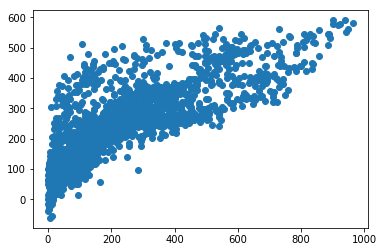

In [11]:
plt.scatter(y_test,predictions)

/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0.5, 1.0, 'real vs predicted distribution')]

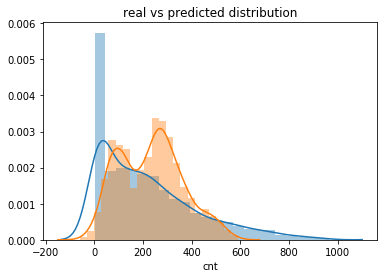

In [12]:
# real vs predicted distribution
fig, ax = plt.subplots()
sns.distplot(y_test)
sns.distplot(predictions)
ax.set(title="real vs predicted distribution")

In [13]:
print("R-square: ",metrics.r2_score(y_test,predictions))

R-square:  0.635146978524876


In [14]:
# Linear regression with Dask
import dask
from dask_ml.linear_model import LinearRegression as dask_LinearRegression

In [15]:
X_train_dask = df_train.drop(["dteday", "cnt","casual","registered"], axis=1)
y_train_dask = df_train["cnt"]
X_test_dask = df_test.drop(["dteday", "cnt","casual","registered"], axis=1)
y_test_dask = df_test["cnt"]

In [16]:
dask_linear = dask_LinearRegression()
dask_linear.fit(X_train_dask.compute().values, y_train_dask.compute().values)
predictions_dask= dask_linear.predict(X_test_dask.compute().values)

In [17]:
print("R-square: ",metrics.r2_score(y_test_dask,predictions_dask))

R-square:  0.6344528898096388


### Now let's try a Decision Tree

In [18]:
Client_d = Client()
Client_d

Client Scheduler: tcp://127.0.0.1:57815 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


R-square:  0.5746118410707615


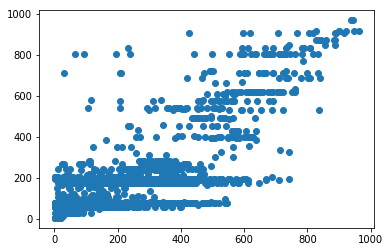

In [19]:
from sklearn.tree import DecisionTreeRegressor

dtm = DecisionTreeRegressor(max_depth=10)
# Using training data to fit the model
with parallel_backend('dask'):
    dtm.fit(X_train, y_train)

predictions = dtm.predict(X_test)
plt.scatter(y_test,predictions)
print("R-square: ",metrics.r2_score(y_test,predictions))

In [20]:
#Hyperparameter tuning with GridSearchCV¶


param_grid = {"min_samples_split": range(10,500,20),
              "max_depth": range(1,20,2)              
             }

grid_cv_dtm = GridSearchCV(dtm, param_grid, cv=5)
grid_cv_dtm.fit(X_train,y_train)



GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': range(10, 500, 20), 'max_depth': range(1, 20, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [21]:
best_parameters = grid_cv_dtm.best_params_
best_parameters

{'max_depth': 19, 'min_samples_split': 30}

R-square:  0.7346059600749111


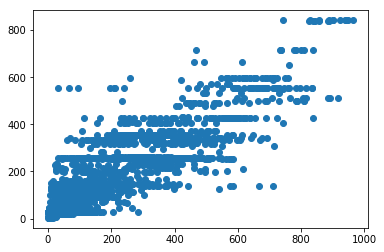

In [22]:
#using the best parameters found
dtm = DecisionTreeRegressor(max_depth=19, min_samples_split=70)
# Using training data to fit the model
with parallel_backend('dask'):
    dtm.fit(X_train, y_train)

predictions=dtm.predict(X_test)
plt.scatter(y_test,predictions)
print("R-square: ",metrics.r2_score(y_test,predictions))

/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0.5, 1.0, 'real vs predicted distribution')]

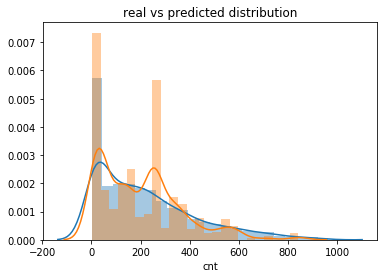

In [23]:
# real vs predicted distribution
fig, ax = plt.subplots()
sns.distplot(y_test)
sns.distplot(predictions)
ax.set(title="real vs predicted distribution")

### Trying a Random Forest Regression

/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


R-square:  0.8423854553133067


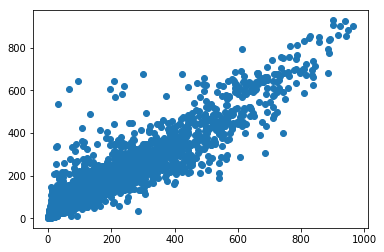

In [24]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor()

# Using training data to fit the model
with parallel_backend('dask'):
    regressor.fit(X_train, y_train)

predictions=regressor.predict(X_test)
plt.scatter(y_test,predictions)
print("R-square: ",metrics.r2_score(y_test,predictions))

In [25]:
#tuning Hyperparameters
parameters = [{'n_estimators' : [150,200,250,300], 'max_features' : ['auto','sqrt','log2']}]
grid_search = GridSearchCV(estimator = regressor, param_grid = parameters)
grid_search = grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_


/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [26]:
best_parameters

{'max_features': 'auto', 'n_estimators': 300}

R-square:  0.8558832195939226


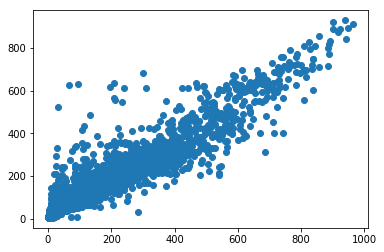

In [28]:
#using the best parameters found
regressor = RandomForestRegressor(n_estimators = 300, max_features = 'auto') 
# Using training data to fit the model
with parallel_backend('dask'):
    regressor.fit(X_train, y_train)

predictions=regressor.predict(X_test)
plt.scatter(y_test,predictions)
print("R-square: ",metrics.r2_score(y_test,predictions))

/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0.5, 1.0, 'real vs predicted distribution')]

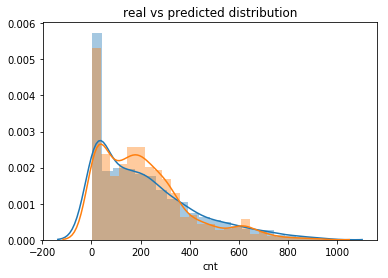

In [29]:
# real vs predicted distribution
fig, ax = plt.subplots()
sns.distplot(y_test)
sns.distplot(predictions)
ax.set(title="real vs predicted distribution")

### Finally, let's try a XGBoost

In [30]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

In [31]:
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=42, colsample_bytree= 0.3,learning_rate= 0.1,
                max_depth= 5)

In [32]:
# Using training data to fit the model
with parallel_backend('dask'):
    xgb_model.fit(X_train, y_train)

/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


R-square:  0.7705284393820431


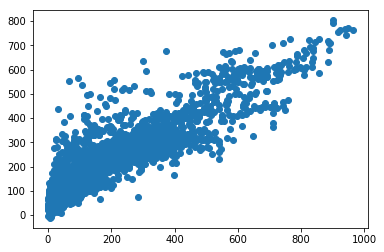

In [33]:
predictions=xgb_model.predict(X_test)
plt.scatter(y_test,predictions)
print("R-square: ",metrics.r2_score(y_test,predictions))

In [34]:
#tuning Hyperparameters
parameters = [{"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }]
grid_search = GridSearchCV(estimator = xgb_model, param_grid = parameters)
grid_search = grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
best_parameters

/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/vanessalopezgarcia/anaconda3/lib/python3.7/s

/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and wi

/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and wi

/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and wi

/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and wi

/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and wi

/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and wi

/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and wi

KeyboardInterrupt: 

/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


R-square:  0.8311609173381376


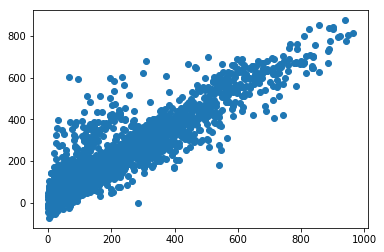

In [35]:
xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=42, colsample_bytree= 0.5,learning_rate= 0.2,
                max_depth= 6)

xgb_model.fit(X_train,y_train)
predictions=xgb_model.predict(X_test)
plt.scatter(y_test,predictions)
print("R-square: ",metrics.r2_score(y_test,predictions))

/Users/vanessalopezgarcia/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0.5, 1.0, 'real vs predicted distribution')]

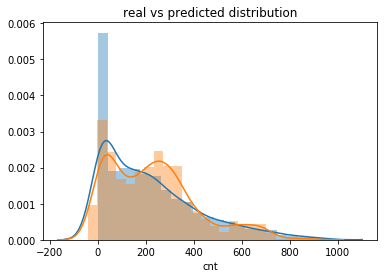

In [23]:
# real vs predicted distribution
fig, ax = plt.subplots()
sns.distplot(y_test)
sns.distplot(predictions)
ax.set(title="real vs predicted distribution")

From the 4 different models tested, XGBoost had the best performance, with an R-score of 0.867. Now let's explore more this model.

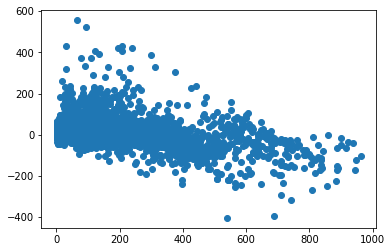

In [24]:
#Plot residuals
plt.scatter(y_test,predictions-y_test)


From the residuals plot above, we see that the model is best at predicting values below 400.

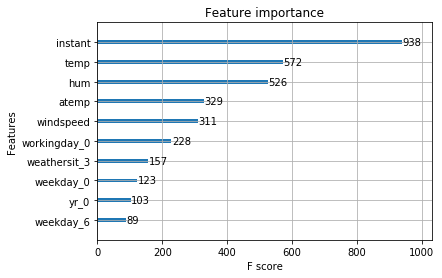

In [25]:
xgb.plot_importance(xgb_model, max_num_features=10)

The most important features for predicting demand are related to the weather (temperature, humidity and wind speed).

As a conclusion, it is worth to mention that using the XGBoost model we successfully predict the bike sharing rental count with relatively high accuracy. 
The XGboost model is the best performing one for our data with an R-score of 0.867. 